## plotNWT_hillslope_simple
#### Plots results from hillslope simulation
- Obs here are flux tower data, included in met forcing data
- Created by Will Wieder, Sept 28, 2021

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='2GB')
cluster.scale(5)

In [4]:
cluster

### Point to files

In [5]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft
site  = ['MM']
longSite  =  ['moist meadow']#'dry_meadow'
case  =  ['NEON_NIWO_hh_test']
rollHour = -12  
years = range(307,308)
nmon  = 12

#OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
#OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
#OUTdir = OBSdir
#print(OBSfile)

dirIn = ['/glade/scratch/wwieder/archive/'+case[c]+'/lnd/hist/' for c in range(len(case))]
files = [dirIn[0] + case[0] +'.clm2.h1.0'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
print(files[0])

/glade/scratch/wwieder/archive/NEON_NIWO_hh_test/lnd/hist/NEON_NIWO_hh_test.clm2.h1.0307-01-01-00000.nc


--- 
### Read in dataset 
- get rid of extra dimensions
- remove CLM time shift

In [6]:
%%time
ds = utils.time_set_mid(xr.open_mfdataset(files, decode_times=True, combine='by_coords'), 'time')
print('---- read  in data  ----')

---- read  in data  ----
CPU times: user 650 ms, sys: 125 ms, total: 775 ms
Wall time: 6.7 s


In [7]:
ds#.SNOW_DEPTH

<xarray.Dataset>
Dimensions:             (column: 12, gridcell: 1, hist_interval: 2, landunit: 1, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, pft: 12, time: 17520)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * time                (time) object 0306-12-31 23:45:00 ... 0307-12-31 23:1...
Dimensions without coordinates: column, gridcell, hist_interval, landunit, lndgrid, pft
Data variables: (12/82)
    hslp_distance       (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_width          (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_area           (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_elev           (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_slope          (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    hslp_aspect         (column) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    ...                  ...
    QDISCHARGE          (time, column) float32 dask.array<chunksize=(17520, 12), meta=np.ndarray>
    QLATFLOWOUT         (time, column) float32 dask.array<chunksize=(17520, 12), meta=np.ndarray>
    SNOW_DEPTH          (time, column) float32 dask.array<chunksize=(17520, 12), meta=np.ndarray>
    SOILC_vr            (time, levsoi, column) float32 dask.array<chunksize=(17520, 20, 12), meta=np.ndarray>
    TBOT                (time, column) float32 dask.array<chunksize=(17520, 12), meta=np.ndarray>
    TSOI                (time, levgrnd, column) float32 dask.array<chunksize=(17520, 25, 12), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 09/24/21 10:25:43
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     minute_30
    Time_constant_3Dvars_filename:        ./NEON_NIWO_hh_test.clm2.h0.0208-01.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

### Sample surface dataset has 
- 4 aspects [0:2], [3:5], [6:8] & [9:11], which corresponded to `hslp_index` 
- 3 elevation classes low = [0,3,6,9], high = [2,5,8,11]
- all columns have arctic C3 grass
- not sure what `hslp_cold` is about, but it seems to have missing values for the highest elevation columns.  Also, lateral flow is more regular from these columns (see plot below)

In [28]:
print(ds.hslp_aspect.values)
print()
print(ds.hslp_elev.values)
print()
print(ds.pfts1d_itype_veg.values)
print()
print(ds.hslp_cold.values)


[0.         0.         0.         1.57079633 1.57079633 1.57079633
 3.14159265 3.14159265 3.14159265 4.71238898 4.71238898 4.71238898]

[0.83333333 2.5        4.16666667 0.83333333 2.5        4.16666667
 0.83333333 2.5        4.16666667 0.83333333 2.5        4.16666667]

[12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]

[    2     3 -9999     5     6 -9999     8     9 -9999    11    12 -9999]


In [29]:
ds.hslp_cold


<xarray.DataArray 'hslp_cold' (column: 12)>
dask.array<open_dataset-542c56542ce87516018a55bc86d592behslp_cold, shape=(12,), dtype=int32, chunksize=(12,), chunktype=numpy.ndarray>
Dimensions without coordinates: column
Attributes:
    long_name:  hillslope downhill column index

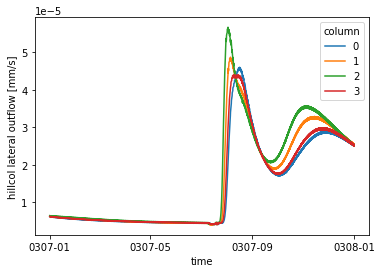

In [30]:
ds.isel(column=[2,5,8,11]).QLATFLOWOUT.plot(hue='column') ;

In [31]:
# patch level variables dimensioned by pft, but also n=12, actually one for each column?
ds.GPP

<xarray.DataArray 'GPP' (time: 17520, pft: 12)>
dask.array<open_dataset-542c56542ce87516018a55bc86d592beGPP, shape=(17520, 12), dtype=float32, chunksize=(17520, 12), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0306-12-31 23:45:00 ... 0307-12-31 23:15:00
Dimensions without coordinates: pft
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

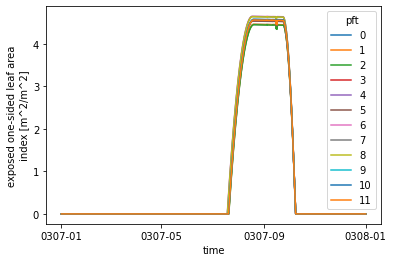

In [32]:
ds.ELAI.plot(hue='pft');

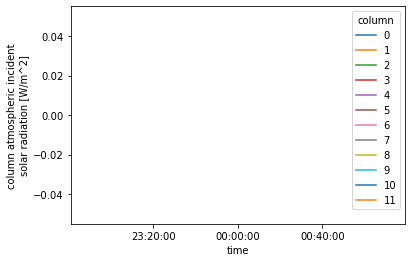

In [40]:
ds.FSDS_COL.plot(hue='column') ;

In [34]:
# Reverse axes here
ds['levsoi'] = ds.levsoi * -1

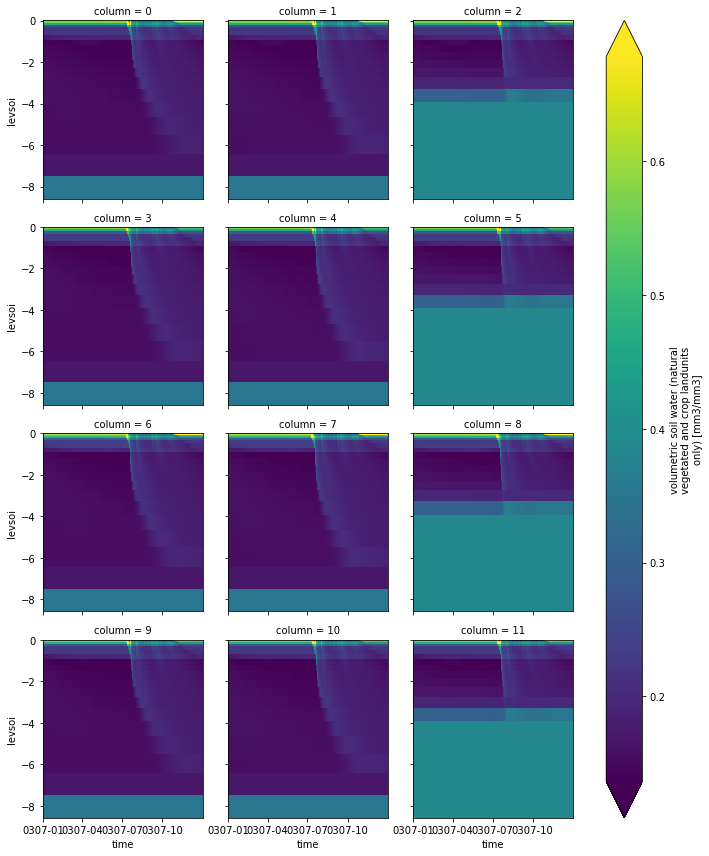

In [38]:
g_simple = ds.H2OSOI.plot(x="time", y="levsoi", col="column", col_wrap=3, robust=True)

In [36]:
ds['levgrnd'] = ds.levgrnd * -1

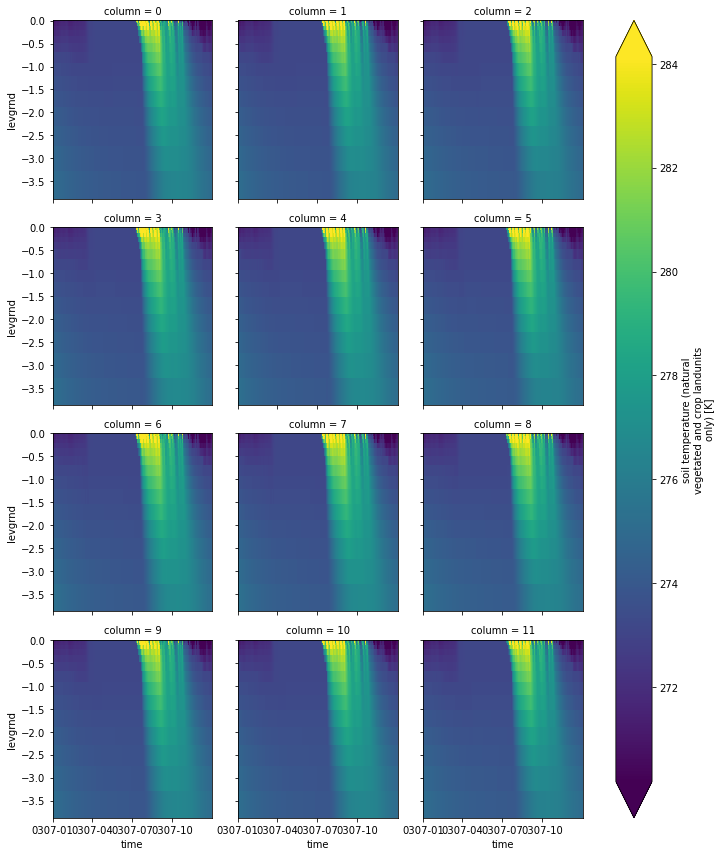

In [39]:
g_simple = ds.isel(levgrnd=slice(0,15)).TSOI.plot(x="time", y="levgrnd", col="column", col_wrap=3, robust=True)

---------------
## Diel cycle

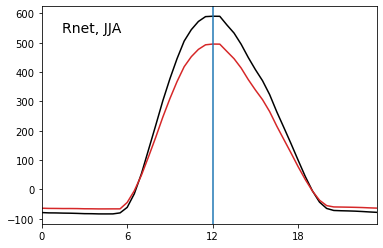

In [12]:
# quick look at one season, variable
v, i = 0, 2
obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

fig, ax = plt.subplots()
ax.plot(obsX.HourMin, obsX, '-', color='k')
#ax.fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax.plot(clmX.HourMin, clmX, '-',color='tab:red')
#ax.fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
ax.text(0.15, 0.90,(Var[v]+', '+Season[i]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);
ax.axvline(x=12)
plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0));

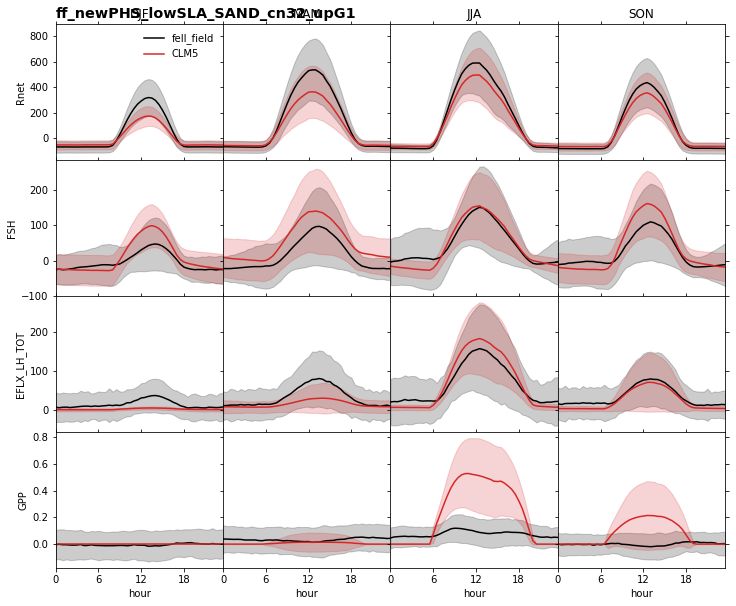

In [13]:
# This is really slow, not sure why.
fig, axs = plt.subplots(len(Var), len(Season), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    xmin = dsOBS[Var[v]].min()
    xmax = dsOBS[Var[v]].max()
    for i in range(len(Season)):
        # maybe use resample, not grouby, 
        # eg da.resample(time='1D').mean()
        obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

        axs[v,i].plot(obsX.HourMin, obsX, '-', color='k')
        axs[v,i].fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
        axs[v,i].plot(clmX.HourMin, clmX, '-',color='tab:red')
        axs[v,i].fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
        axs[v,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
        axs[v,i].xaxis.set_ticks_position('both')     

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            if i == 0:
                axs[v,i].legend([longSite,'CLM5'], frameon=False)
                axs[v,i].set_title(site[0], loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel('hour')
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel(Var[v]) 

plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0))
#axs[0,0].legend((network+' '+longSite),'CLM5', frameon=False)

plt.savefig(OUTdir+site[0]+'_FluxDiel.pdf');

### Plot mean annual cycle

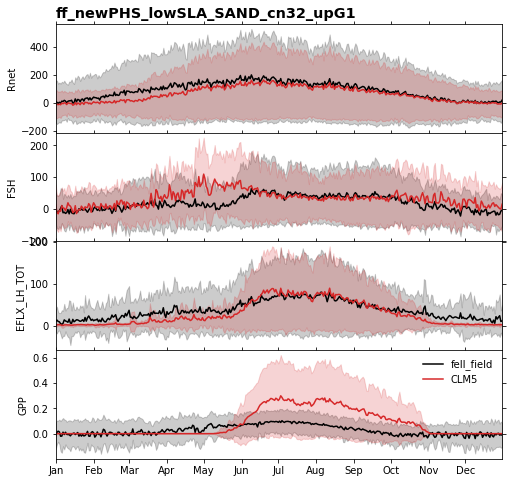

In [14]:
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%b')

fig, axs = plt.subplots(len(Var),1, sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(8,8))
for v in range(len(Var)):
    # using groupby('time.dayofyear') gives too many days in leap year
    # use variable MonDay  instead
    x = dsOBS['time'].groupby(dsOBS.MonDay).min()
    obsX = dsOBS[Var[v]].groupby(dsOBS.MonDay).mean()
    clmX = dsCLM[Var[v]].groupby(dsOBS.MonDay).mean()
    obsSD = dsOBS[Var[v]].groupby(dsOBS.MonDay).std()
    clmSD = dsCLM[Var[v]].groupby(dsOBS.MonDay).std()
        
    axs[v].plot(x, obsX, '-', color='k')
    axs[v].fill_between(x, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
    axs[v].plot(x, clmX, '-',color='tab:red')
    axs[v].fill_between(x, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
    axs[v].set_ylabel(Var[v])       
    axs[v].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
    axs[v].xaxis.set_ticks_position('both')     

    # set  x axis limits
    axs[v].format_xdata = mdates.DateFormatter('%Y-%m-%d')
    axs[v].xaxis.set_major_locator(months)
    axs[v].xaxis.set_major_formatter(months_fmt)
    datemin = np.datetime64(x[0].values, 'm')
    datemax = np.datetime64(x[-1].values, 'm') 
    axs[v].set_xlim(datemin, datemax)

    # control titles & axis labels
    if v == 0: 
        axs[v].set_title(site[0], loc='left', fontsize='x-large', fontweight='bold')

plt.legend([longSite,'CLM5'], frameon=False)

#fig.autofmt_xdate()
plt.savefig(OUTdir+site[0]+'_FluxAnnual.pdf');

In [15]:
print(OUTdir)

/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/fell_field/


--------------------------
## Plot depth-time plots of soil moisture and temperature
--------------------------

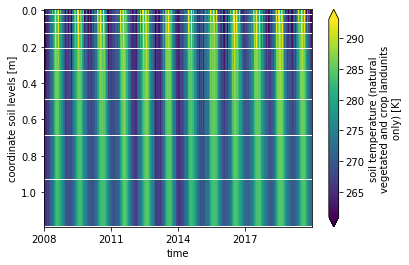

In [16]:
dsCLM.TSOI.isel(levgrnd=(slice(0,9))).plot(x="time",yincrease=False, robust=True);

In [17]:
dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values

array([0.01, 0.04, 0.09, 0.16, 0.26, 0.4 , 0.58, 0.8 , 1.06, 1.36, 1.7 ,
       2.08, 2.5 , 2.99, 3.58, 4.27, 5.06, 5.95, 6.94, 8.03],
      dtype=float32)

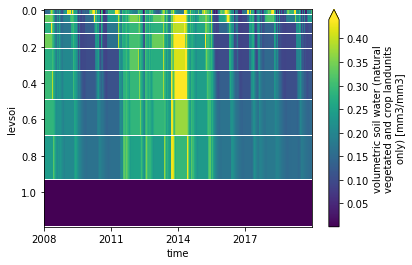

In [18]:
temp = dsCLM['H2OSOI'].copy(deep=True)
temp = temp.assign_coords({"levsoi": dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values})
#dsCLM.H2OSOI.levsoi  =  dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values
temp.isel(levsoi=(slice(0,9))).plot(x="time",yincrease=False, robust=True);

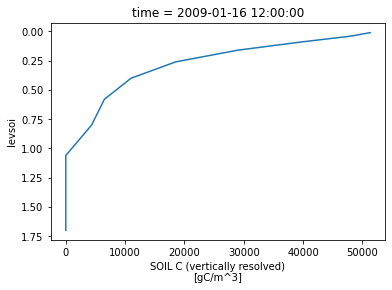

In [19]:
temp = dsCLMmon.SOILC_vr.copy(deep=True)
temp = temp.assign_coords({"levsoi": dsCLM["levgrnd"].isel(levgrnd=slice(0,20)).values})
temp.isel(levsoi=(slice(0,11))).plot(y='levsoi',yincrease=False);


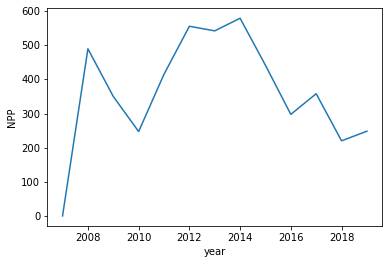

In [20]:
annPPT = dsCLM['ppt'].groupby(dsCLM['year']).mean()
annPPT = annPPT * 3600 * 24 * 365 / 10  #convert mm/s to cm/y
annNPP = dsCLM['NPP'].groupby(dsCLM['year']).mean()
annNPP = annNPP * 3600 * 24 * 365  #convert gC/m2/s gC/m2/y
annNPP.plot();

In [21]:
%%time 
#dsCLM_day = dsCLM.resample(time='1D').mean()
#dsCLM2_day = dsCLM2.resample(time='1D').mean()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


gC/m2/h


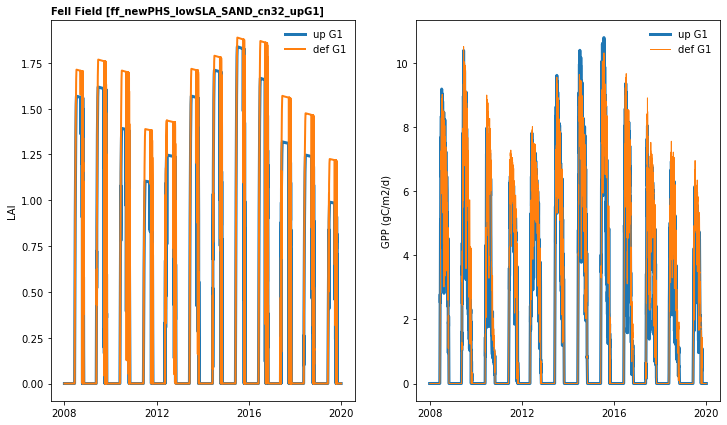

In [22]:
s2d = 60 * 60 *24
plt.figure(figsize=[12,7])
plt.subplot(1,2,1)
plt.plot(dsCLM.time, dsCLM.ELAI, lw=3)
plt.plot(dsCLM2.time, dsCLM2.ELAI, lw=2)
plt.legend(['up G1','def G1'],frameon=False,fontsize='medium',loc='upper right')
plt.title('Fell Field ['+site[0]+']', loc='left', fontsize='medium', fontweight='bold');
plt.ylabel('LAI')        

print(dsCLM.GPP.attrs['units'])
plt.subplot(1,2,2)
plt.plot(dsCLM.time.resample(time='1D').mean(), 
         dsCLM.GPP.resample(time='1D').mean()*24, 
         lw=3)
plt.plot(dsCLM2.time.resample(time='1D').mean(), 
         dsCLM2.GPP.resample(time='1D').mean()*24, 
         lw=1)
plt.legend(['up G1','def G1'],frameon=False,fontsize='medium',loc='upper right')
#plt.title('Fell Field ['+site[0]+']', loc='left', fontsize='medium', fontweight='bold');
plt.ylabel('GPP (gC/m2/d)');

In [23]:
# annual GPP
# Warning, observed GPP data has lots of missing values
annGPPobs = (dsOBS.GPP.groupby('time.year').mean()*24*365)
annGPP_1 = (dsCLM.GPP.resample(time='1Y').mean()*24*365)
annNPP_1 = (dsCLM.NPP.resample(time='1Y').mean()*3600*24*365)
annAR_1 = (dsCLM.AR.resample(time='1Y').mean()*3600*24*365)
annGPP_2 = (dsCLM2.GPP.resample(time='1Y').mean()*24*365)
annNPP_2 = (dsCLM2.NPP.resample(time='1Y').mean()*3600*24*365)
print('obs GPP  = '+ str(np.round(annGPPobs.mean().values,1))+' +/- '+
      str(np.round(annGPPobs.std().values,1)) +' gC/m2/y')
print('up G1 GPP  = '+ str(np.round(annGPP_1.mean().values,1))+' +/- '+
      str(np.round(annGPP_1.std().values,1)) +' gC/m2/y')
print('def G1 GPP = '+str(np.round(annGPP_2.mean().values, 1))+' +/- '+
      str(np.round(annGPP_2.std().values,1)) +' gC/m2/y')
print('')
print('up G1 NPP  = '+ str(np.round(annNPP_1.mean().values,1))+' +/- '+
      str(np.round(annNPP_1.std().values,1)) +' gC/m2/y')
print('up G2 NPP  = '+ str(np.round(annNPP_2.mean().values,1))+' +/- '+
      str(np.round(annNPP_1.std().values,1)) +' gC/m2/y')
print('up G1 AR  = '+ str(np.round(annAR_1.mean().values,1))+' +/- '+
      str(np.round(annAR_1.std().values,1)) +' gC/m2/y')

obs GPP  = 227.7 +/- 195.0 gC/m2/y
up G1 GPP  = 639.9 +/- 235.8 gC/m2/y
def G1 GPP = 733.2 +/- 244.2 gC/m2/y

up G1 NPP  = 364.9 +/- 157.8 gC/m2/y
up G2 NPP  = 418.7 +/- 157.8 gC/m2/y
up G1 AR  = 275.0 +/- 98.7 gC/m2/y


- GPP is still to high, but 
- Increasing G1 reduces annual GPP flux, but increases IAV
- I'm surprised AR fluxes are not higher... I wonder why, maybe the low C:N used here?

In [24]:
dsCLM.AR

<xarray.DataArray 'AR' (time: 210240)>
dask.array<rechunk-merge, shape=(210240,), dtype=float32, chunksize=(35040,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2007-12-31 23:44:59.999993 ... 2019-12-31 23:15:00
Attributes:
    long_name:     autotrophic respiration (MR + GR)
    units:         gC/m^2/s
    cell_methods:  time: mean

## OBS GPP by year

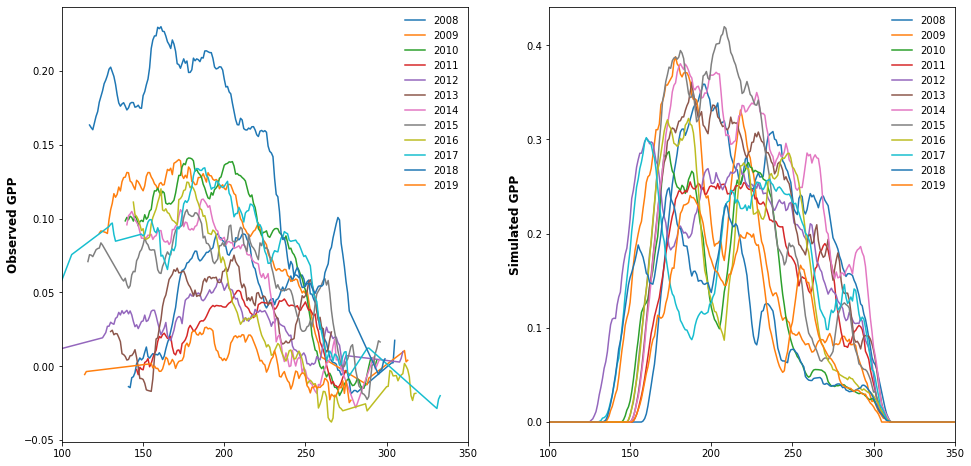

In [25]:
plt.figure(figsize=[16,8])

# doing this in a loop seems dumb & slow, but it works
for j in range(2):
    plt.subplot(1,2,(j+1))
    plt.xlim((100, 350)) 
    if j == 0: plt.ylabel('Observed GPP', fontsize='large', fontweight='bold')
    else: plt.ylabel('Simulated GPP', fontsize='large', fontweight='bold');

    for i in range(len(years)):
        I = i + 0  #if fewer years are prefered

        #subset year of data
        if j == 0: 
            dsPlot = dsOBS.where(dsOBS['year']==years[I])
        else: 
            dsPlot = dsCLM.where(dsCLM['year']==years[I])

        # daily means
        x = dsPlot['time.dayofyear'].groupby(dsPlot['time.dayofyear']).min()
        y = dsPlot.get('GPP').where(dsPlot['year']==years[I]).groupby(dsPlot['time.dayofyear']).mean().chunk(chunks=1)
        # mask out Daily GPP where TBOT<-4
        if j == 0:
            z = dsPlot.get('TBOT').where(dsPlot['year']==years[I]).groupby(dsPlot['time.dayofyear']).mean()
            y = y.where(z>269)

        #  10 day rolling mean
        y = y.chunk(chunks=10).rolling(dayofyear=10, center=True).mean().dropna("dayofyear")
        plt.plot(y.dayofyear, y, '-')

    plt.legend(years, frameon=False, loc='upper right');

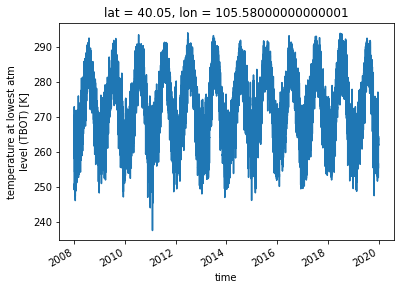

In [26]:
dsOBS['TBOT'].plot()

### Soil moisture by year

range(2007, 2020)
2014
2015
2016
2017


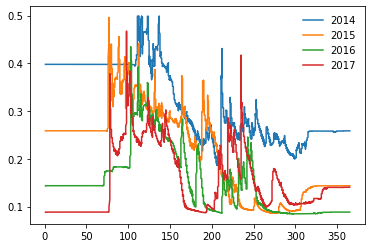

In [27]:
years = range(dsCLM['year'].values.min(), (dsCLM['year'].values.max()+1))
nyear = 4 
print(years)
for i in range(nyear):
    I = i + 7
    print(years[I])
    x = dsCLM['time.dayofyear'].where(dsCLM['year']==years[I])
    y = dsCLM.get('H2OSOI').isel(levsoi=2).where(dsCLM['year']==years[I])
    plt.plot(x, y, '-')

plt.legend(years[7:11], frameon=False, loc='upper right');

-----------------
### look into sources of potential flux errors

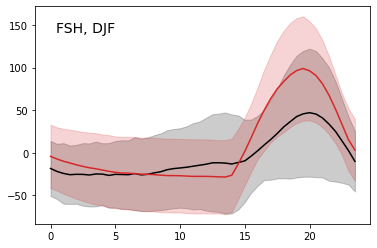

In [28]:
Var = ['FSH','TBOT','FSDS','FLDS']
v = 0
i = 0
obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean()
clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean()#.roll(HourMin=rollHour, roll_coords=False)
obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std()
clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std()#.roll(HourMin=rollHour, roll_coords=False)

fig, ax = plt.subplots()
ax.plot(obsX.HourMin, obsX, '-', color='k')
ax.fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax.plot(clmX.HourMin, clmX, '-',color='tab:red')
ax.fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
ax.text(0.15, 0.90,(Var[v]+', '+Season[i]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);

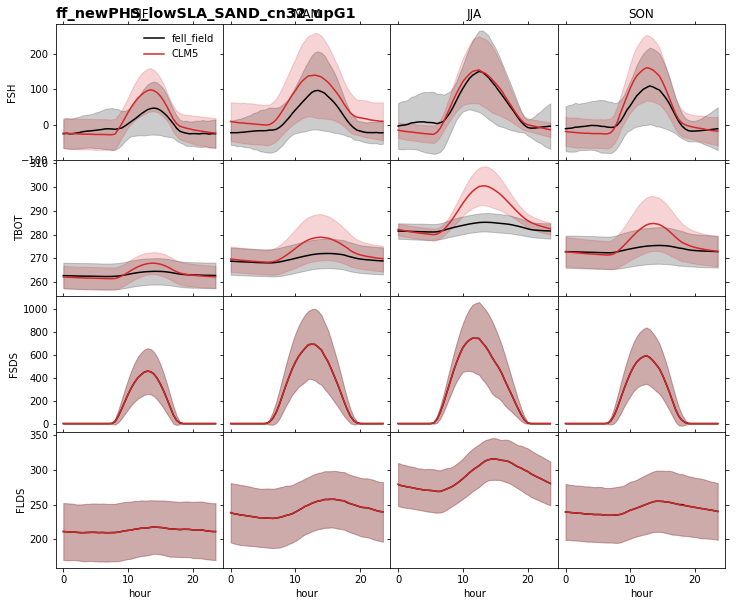

In [29]:
# This is really slow, not sure why.
fig, axs = plt.subplots(len(Var), len(Season), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    for i in range(len(Season)):
        obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        if Var[v]!='TBOT':
            clmX = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
            clmSD = dsCLM[Var[v]].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        else:
            clmX = dsCLM['TG'].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
            clmSD = dsCLM['TG'].where(dsCLM.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

            
        axs[v,i].plot(obsX.HourMin, obsX, '-', color='k')
        axs[v,i].fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
        axs[v,i].plot(clmX.HourMin, clmX, '-',color='tab:red')
        axs[v,i].fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
        axs[v,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
        axs[v,i].xaxis.set_ticks_position('both')     

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            if i == 0:
                axs[v,i].legend([longSite,'CLM5'], frameon=False)
                axs[v,i].set_title(site[0], loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel('hour')
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel(Var[v]) 